# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [60]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

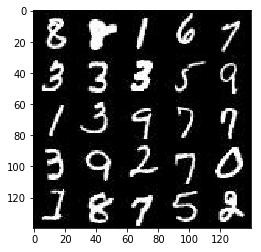

In [61]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

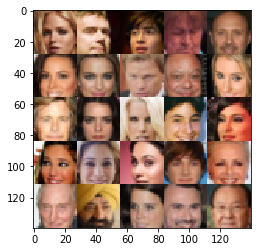

In [62]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [63]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [64]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [149]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
    
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.get_shape())
        # 4x4x256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
                
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [150]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
        
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
                
        #print(x1.get_shape())
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.get_shape())
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_chanel_dim
        
        out = tf.tanh(logits)
        
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [151]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [152]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [153]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [154]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    width = data_shape[1]
    height = data_shape[2]
    out_channel_dim = data_shape[3]
    
    
    real_input, z_input, lr = model_inputs(width, height, out_channel_dim, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    show_every = 100
    print_every = 10
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1                
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={real_input: batch_images, z_input: batch_z})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, real_input: batch_images})
                
                
                if steps % show_every == 0:
                    show_generator_output(sess, 10, z_input, out_channel_dim, data_image_mode)
                    
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),                          
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
            
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2822... Generator Loss: 1.8173
Epoch 1/2... Discriminator Loss: 0.4816... Generator Loss: 1.4360
Epoch 1/2... Discriminator Loss: 0.4759... Generator Loss: 2.1641
Epoch 1/2... Discriminator Loss: 0.6341... Generator Loss: 1.2003
Epoch 1/2... Discriminator Loss: 0.4073... Generator Loss: 1.6050
Epoch 1/2... Discriminator Loss: 0.7515... Generator Loss: 0.8799
Epoch 1/2... Discriminator Loss: 0.4735... Generator Loss: 1.4153
Epoch 1/2... Discriminator Loss: 0.3755... Generator Loss: 1.6513
Epoch 1/2... Discriminator Loss: 0.5500... Generator Loss: 2.1070


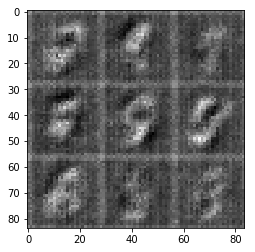

Epoch 1/2... Discriminator Loss: 0.4516... Generator Loss: 2.0957
Epoch 1/2... Discriminator Loss: 0.4917... Generator Loss: 2.1453
Epoch 1/2... Discriminator Loss: 0.4816... Generator Loss: 1.3689
Epoch 1/2... Discriminator Loss: 1.1199... Generator Loss: 0.4837
Epoch 1/2... Discriminator Loss: 0.4038... Generator Loss: 1.6949
Epoch 1/2... Discriminator Loss: 0.4307... Generator Loss: 2.9338
Epoch 1/2... Discriminator Loss: 0.3582... Generator Loss: 1.8064
Epoch 1/2... Discriminator Loss: 0.3046... Generator Loss: 1.9969
Epoch 1/2... Discriminator Loss: 0.2868... Generator Loss: 2.3759
Epoch 1/2... Discriminator Loss: 0.3004... Generator Loss: 1.7423


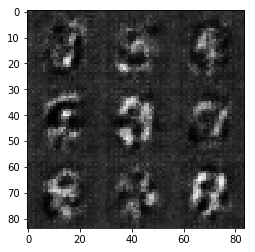

Epoch 1/2... Discriminator Loss: 0.1813... Generator Loss: 2.5133
Epoch 1/2... Discriminator Loss: 0.1898... Generator Loss: 3.3923
Epoch 1/2... Discriminator Loss: 0.2162... Generator Loss: 1.9508
Epoch 1/2... Discriminator Loss: 0.2669... Generator Loss: 1.8169
Epoch 1/2... Discriminator Loss: 0.1579... Generator Loss: 2.6298
Epoch 1/2... Discriminator Loss: 0.1304... Generator Loss: 2.7210
Epoch 1/2... Discriminator Loss: 0.2029... Generator Loss: 2.2689
Epoch 1/2... Discriminator Loss: 1.1618... Generator Loss: 4.9839
Epoch 1/2... Discriminator Loss: 0.2133... Generator Loss: 2.3038
Epoch 1/2... Discriminator Loss: 0.1921... Generator Loss: 2.7858


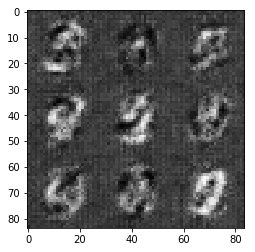

Epoch 1/2... Discriminator Loss: 1.9266... Generator Loss: 0.2174
Epoch 1/2... Discriminator Loss: 0.2796... Generator Loss: 2.1069
Epoch 1/2... Discriminator Loss: 0.2200... Generator Loss: 2.4564
Epoch 1/2... Discriminator Loss: 0.1388... Generator Loss: 2.7833
Epoch 1/2... Discriminator Loss: 0.3580... Generator Loss: 4.2486
Epoch 1/2... Discriminator Loss: 0.2359... Generator Loss: 2.3187
Epoch 1/2... Discriminator Loss: 0.1851... Generator Loss: 3.4979
Epoch 1/2... Discriminator Loss: 0.1282... Generator Loss: 2.9043
Epoch 1/2... Discriminator Loss: 0.1764... Generator Loss: 2.3319
Epoch 1/2... Discriminator Loss: 0.1485... Generator Loss: 2.6755


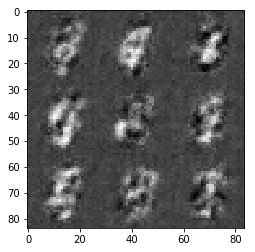

Epoch 1/2... Discriminator Loss: 0.1740... Generator Loss: 3.9589
Epoch 1/2... Discriminator Loss: 0.2331... Generator Loss: 2.3554
Epoch 1/2... Discriminator Loss: 0.1865... Generator Loss: 2.5349
Epoch 1/2... Discriminator Loss: 0.1327... Generator Loss: 2.8150
Epoch 1/2... Discriminator Loss: 0.1210... Generator Loss: 3.0569
Epoch 1/2... Discriminator Loss: 0.1107... Generator Loss: 3.3212
Epoch 1/2... Discriminator Loss: 0.1481... Generator Loss: 2.9229
Epoch 2/2... Discriminator Loss: 0.0923... Generator Loss: 3.2933
Epoch 2/2... Discriminator Loss: 0.1081... Generator Loss: 3.2408
Epoch 2/2... Discriminator Loss: 0.1172... Generator Loss: 2.9381


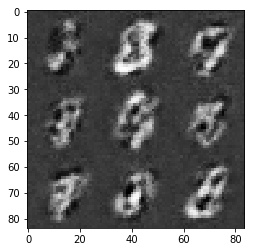

Epoch 2/2... Discriminator Loss: 0.1160... Generator Loss: 3.0442
Epoch 2/2... Discriminator Loss: 0.1132... Generator Loss: 3.5264
Epoch 2/2... Discriminator Loss: 0.0908... Generator Loss: 3.3659
Epoch 2/2... Discriminator Loss: 0.0843... Generator Loss: 3.6297
Epoch 2/2... Discriminator Loss: 0.1143... Generator Loss: 2.9246
Epoch 2/2... Discriminator Loss: 0.0843... Generator Loss: 3.5717
Epoch 2/2... Discriminator Loss: 0.1488... Generator Loss: 2.4137
Epoch 2/2... Discriminator Loss: 0.0909... Generator Loss: 3.8624
Epoch 2/2... Discriminator Loss: 0.1002... Generator Loss: 2.9639
Epoch 2/2... Discriminator Loss: 0.0879... Generator Loss: 3.6706


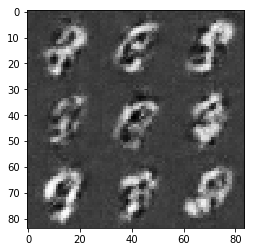

Epoch 2/2... Discriminator Loss: 0.0679... Generator Loss: 3.9134
Epoch 2/2... Discriminator Loss: 0.0766... Generator Loss: 3.3347
Epoch 2/2... Discriminator Loss: 0.0857... Generator Loss: 3.3171
Epoch 2/2... Discriminator Loss: 0.0831... Generator Loss: 3.2594
Epoch 2/2... Discriminator Loss: 0.0778... Generator Loss: 3.8824
Epoch 2/2... Discriminator Loss: 0.0783... Generator Loss: 3.5715
Epoch 2/2... Discriminator Loss: 0.0709... Generator Loss: 4.2729
Epoch 2/2... Discriminator Loss: 0.0761... Generator Loss: 3.4463
Epoch 2/2... Discriminator Loss: 0.0647... Generator Loss: 3.5373
Epoch 2/2... Discriminator Loss: 0.0732... Generator Loss: 3.7637


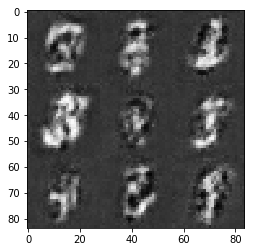

Epoch 2/2... Discriminator Loss: 0.0828... Generator Loss: 3.9866
Epoch 2/2... Discriminator Loss: 0.4339... Generator Loss: 1.2832
Epoch 2/2... Discriminator Loss: 0.2928... Generator Loss: 2.2967
Epoch 2/2... Discriminator Loss: 0.1975... Generator Loss: 2.6580
Epoch 2/2... Discriminator Loss: 0.2249... Generator Loss: 2.3994
Epoch 2/2... Discriminator Loss: 0.1637... Generator Loss: 2.8085
Epoch 2/2... Discriminator Loss: 0.1500... Generator Loss: 3.0059
Epoch 2/2... Discriminator Loss: 0.1485... Generator Loss: 2.6547
Epoch 2/2... Discriminator Loss: 0.1541... Generator Loss: 2.6450
Epoch 2/2... Discriminator Loss: 0.1141... Generator Loss: 3.0435


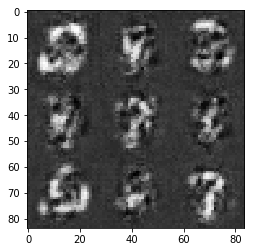

Epoch 2/2... Discriminator Loss: 0.0866... Generator Loss: 3.3374
Epoch 2/2... Discriminator Loss: 0.0855... Generator Loss: 3.4597
Epoch 2/2... Discriminator Loss: 0.0798... Generator Loss: 3.4015
Epoch 2/2... Discriminator Loss: 0.0674... Generator Loss: 3.5182
Epoch 2/2... Discriminator Loss: 0.0556... Generator Loss: 3.6287
Epoch 2/2... Discriminator Loss: 0.0532... Generator Loss: 3.6432
Epoch 2/2... Discriminator Loss: 0.0754... Generator Loss: 3.5294
Epoch 2/2... Discriminator Loss: 0.0566... Generator Loss: 3.5919
Epoch 2/2... Discriminator Loss: 0.0798... Generator Loss: 3.3798
Epoch 2/2... Discriminator Loss: 0.0510... Generator Loss: 4.0757


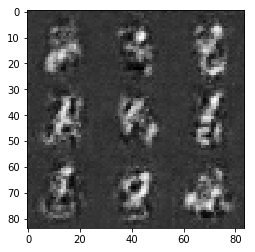

Epoch 2/2... Discriminator Loss: 0.0461... Generator Loss: 3.7816
Epoch 2/2... Discriminator Loss: 0.0589... Generator Loss: 3.6526
Epoch 2/2... Discriminator Loss: 0.0700... Generator Loss: 3.4491
Epoch 2/2... Discriminator Loss: 0.0403... Generator Loss: 4.2028


In [155]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3161... Generator Loss: 1.7911
Epoch 1/1... Discriminator Loss: 0.4458... Generator Loss: 1.4084
Epoch 1/1... Discriminator Loss: 0.1782... Generator Loss: 2.7350
Epoch 1/1... Discriminator Loss: 0.3392... Generator Loss: 1.8373
Epoch 1/1... Discriminator Loss: 4.9683... Generator Loss: 0.0160
Epoch 1/1... Discriminator Loss: 2.4980... Generator Loss: 0.1486
Epoch 1/1... Discriminator Loss: 0.4709... Generator Loss: 1.6902
Epoch 1/1... Discriminator Loss: 0.3422... Generator Loss: 1.9244
Epoch 1/1... Discriminator Loss: 0.4046... Generator Loss: 1.5500


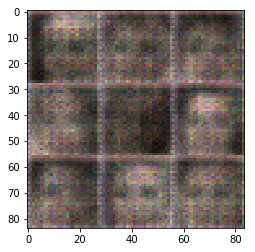

Epoch 1/1... Discriminator Loss: 0.1935... Generator Loss: 2.2840
Epoch 1/1... Discriminator Loss: 0.0777... Generator Loss: 3.4680
Epoch 1/1... Discriminator Loss: 0.1525... Generator Loss: 2.7408
Epoch 1/1... Discriminator Loss: 0.0589... Generator Loss: 4.1526
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 0.7100... Generator Loss: 1.1417
Epoch 1/1... Discriminator Loss: 0.5506... Generator Loss: 1.4743
Epoch 1/1... Discriminator Loss: 0.1607... Generator Loss: 2.6011
Epoch 1/1... Discriminator Loss: 0.7394... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 2.9015... Generator Loss: 0.0756


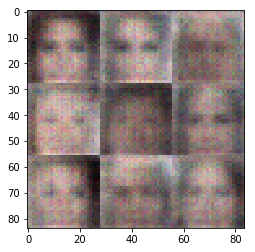

Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 5.2872
Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 1.2497
Epoch 1/1... Discriminator Loss: 0.6996... Generator Loss: 1.3701
Epoch 1/1... Discriminator Loss: 0.3389... Generator Loss: 6.5820
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 0.6876... Generator Loss: 1.0899
Epoch 1/1... Discriminator Loss: 0.4441... Generator Loss: 1.6838
Epoch 1/1... Discriminator Loss: 0.2899... Generator Loss: 2.2636


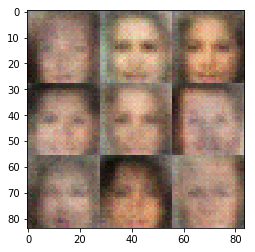

Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 0.7002... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 2.6363
Epoch 1/1... Discriminator Loss: 0.0906... Generator Loss: 4.7257
Epoch 1/1... Discriminator Loss: 0.4225... Generator Loss: 5.1850
Epoch 1/1... Discriminator Loss: 0.1072... Generator Loss: 4.1638
Epoch 1/1... Discriminator Loss: 0.1966... Generator Loss: 4.4685
Epoch 1/1... Discriminator Loss: 0.4590... Generator Loss: 1.6329
Epoch 1/1... Discriminator Loss: 0.0575... Generator Loss: 6.9509


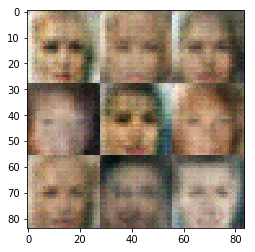

Epoch 1/1... Discriminator Loss: 2.3156... Generator Loss: 0.1621
Epoch 1/1... Discriminator Loss: 0.2239... Generator Loss: 5.0359
Epoch 1/1... Discriminator Loss: 0.1359... Generator Loss: 4.8287
Epoch 1/1... Discriminator Loss: 0.2017... Generator Loss: 4.1808
Epoch 1/1... Discriminator Loss: 0.0977... Generator Loss: 5.2610
Epoch 1/1... Discriminator Loss: 0.1773... Generator Loss: 6.0681
Epoch 1/1... Discriminator Loss: 0.3986... Generator Loss: 1.6337
Epoch 1/1... Discriminator Loss: 0.0369... Generator Loss: 10.2253
Epoch 1/1... Discriminator Loss: 0.1907... Generator Loss: 2.4045
Epoch 1/1... Discriminator Loss: 0.6530... Generator Loss: 1.0332


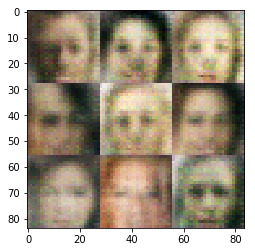

Epoch 1/1... Discriminator Loss: 0.0145... Generator Loss: 9.6750
Epoch 1/1... Discriminator Loss: 0.1365... Generator Loss: 2.3884
Epoch 1/1... Discriminator Loss: 0.1915... Generator Loss: 7.6885
Epoch 1/1... Discriminator Loss: 0.2605... Generator Loss: 2.3692
Epoch 1/1... Discriminator Loss: 0.1719... Generator Loss: 2.1763
Epoch 1/1... Discriminator Loss: 0.2379... Generator Loss: 8.6972
Epoch 1/1... Discriminator Loss: 0.0443... Generator Loss: 7.5929
Epoch 1/1... Discriminator Loss: 0.4681... Generator Loss: 1.4468
Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 6.6278
Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 11.1715


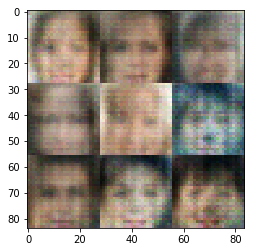

Epoch 1/1... Discriminator Loss: 0.0035... Generator Loss: 8.4024
Epoch 1/1... Discriminator Loss: 0.1200... Generator Loss: 2.8731
Epoch 1/1... Discriminator Loss: 0.0194... Generator Loss: 6.8215
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 10.2836
Epoch 1/1... Discriminator Loss: 0.0449... Generator Loss: 9.3028
Epoch 1/1... Discriminator Loss: 0.0237... Generator Loss: 5.1013
Epoch 1/1... Discriminator Loss: 0.0507... Generator Loss: 9.0595
Epoch 1/1... Discriminator Loss: 0.0340... Generator Loss: 9.1608
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 9.1124
Epoch 1/1... Discriminator Loss: 0.0292... Generator Loss: 10.0395


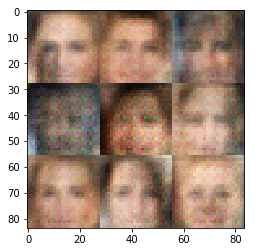

Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 6.9079
Epoch 1/1... Discriminator Loss: 0.0402... Generator Loss: 5.0370
Epoch 1/1... Discriminator Loss: 0.0209... Generator Loss: 8.8508
Epoch 1/1... Discriminator Loss: 0.0230... Generator Loss: 10.7033
Epoch 1/1... Discriminator Loss: 0.0258... Generator Loss: 8.1845
Epoch 1/1... Discriminator Loss: 0.0114... Generator Loss: 10.4751
Epoch 1/1... Discriminator Loss: 0.0056... Generator Loss: 9.7550
Epoch 1/1... Discriminator Loss: 0.0144... Generator Loss: 9.3147
Epoch 1/1... Discriminator Loss: 0.1336... Generator Loss: 10.8987
Epoch 1/1... Discriminator Loss: 0.0165... Generator Loss: 9.3917


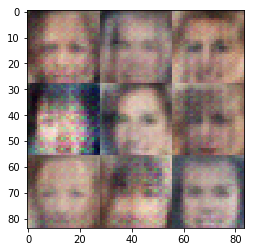

Epoch 1/1... Discriminator Loss: 0.0155... Generator Loss: 9.4718
Epoch 1/1... Discriminator Loss: 0.0623... Generator Loss: 6.3680
Epoch 1/1... Discriminator Loss: 0.0134... Generator Loss: 10.0364
Epoch 1/1... Discriminator Loss: 0.0120... Generator Loss: 8.0207
Epoch 1/1... Discriminator Loss: 0.3558... Generator Loss: 1.4416
Epoch 1/1... Discriminator Loss: 0.0056... Generator Loss: 9.4566
Epoch 1/1... Discriminator Loss: 0.0761... Generator Loss: 10.3644
Epoch 1/1... Discriminator Loss: 0.0051... Generator Loss: 6.9474
Epoch 1/1... Discriminator Loss: 0.0039... Generator Loss: 7.3210
Epoch 1/1... Discriminator Loss: 0.0268... Generator Loss: 6.6461


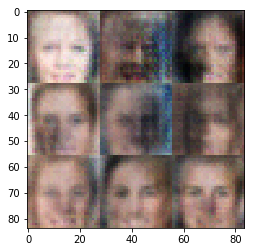

Epoch 1/1... Discriminator Loss: 0.0164... Generator Loss: 5.1409
Epoch 1/1... Discriminator Loss: 0.0090... Generator Loss: 8.6936
Epoch 1/1... Discriminator Loss: 0.0062... Generator Loss: 7.9001
Epoch 1/1... Discriminator Loss: 0.0061... Generator Loss: 6.1651
Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 8.7670
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 11.9910
Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 11.5514
Epoch 1/1... Discriminator Loss: 0.0070... Generator Loss: 8.9660
Epoch 1/1... Discriminator Loss: 0.0199... Generator Loss: 12.9915
Epoch 1/1... Discriminator Loss: 0.0043... Generator Loss: 9.5564


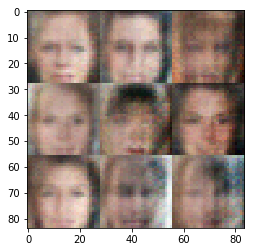

Epoch 1/1... Discriminator Loss: 0.0137... Generator Loss: 5.8909
Epoch 1/1... Discriminator Loss: 0.0026... Generator Loss: 7.9809
Epoch 1/1... Discriminator Loss: 0.1312... Generator Loss: 13.9054
Epoch 1/1... Discriminator Loss: 0.0060... Generator Loss: 8.6111
Epoch 1/1... Discriminator Loss: 0.0093... Generator Loss: 10.1939
Epoch 1/1... Discriminator Loss: 0.0073... Generator Loss: 10.0202
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 8.6760
Epoch 1/1... Discriminator Loss: 0.0086... Generator Loss: 12.0129
Epoch 1/1... Discriminator Loss: 0.0054... Generator Loss: 7.9660
Epoch 1/1... Discriminator Loss: 0.0108... Generator Loss: 12.5651


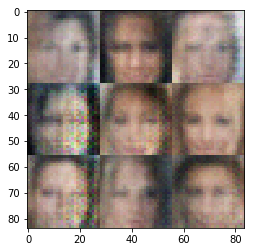

Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 9.2460
Epoch 1/1... Discriminator Loss: 0.0066... Generator Loss: 10.3964
Epoch 1/1... Discriminator Loss: 0.0540... Generator Loss: 3.3283
Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 8.4689
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 9.6715
Epoch 1/1... Discriminator Loss: 0.0088... Generator Loss: 9.8841
Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 6.5976
Epoch 1/1... Discriminator Loss: 0.0069... Generator Loss: 12.5784
Epoch 1/1... Discriminator Loss: 0.0064... Generator Loss: 8.1536
Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 11.1785


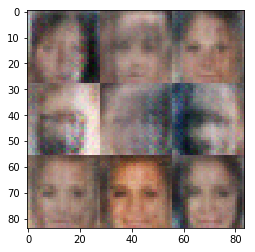

Epoch 1/1... Discriminator Loss: 0.0043... Generator Loss: 10.8632
Epoch 1/1... Discriminator Loss: 0.0254... Generator Loss: 12.7638
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 9.0467
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 10.1157
Epoch 1/1... Discriminator Loss: 0.0023... Generator Loss: 12.0509
Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 10.2530
Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 11.1580
Epoch 1/1... Discriminator Loss: 0.0043... Generator Loss: 7.7581
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 9.8642
Epoch 1/1... Discriminator Loss: 0.0043... Generator Loss: 10.2493


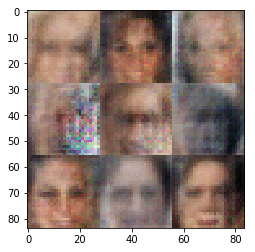

Epoch 1/1... Discriminator Loss: 0.0052... Generator Loss: 8.1810
Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 6.9209
Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 11.7248
Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 9.1894
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 12.1153
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 10.3638
Epoch 1/1... Discriminator Loss: 0.0020... Generator Loss: 7.4868
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 11.5016
Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 13.0579
Epoch 1/1... Discriminator Loss: 0.0032... Generator Loss: 7.2961


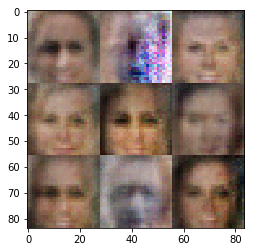

Epoch 1/1... Discriminator Loss: 0.0151... Generator Loss: 5.5538
Epoch 1/1... Discriminator Loss: 0.0074... Generator Loss: 12.6800
Epoch 1/1... Discriminator Loss: 0.0007... Generator Loss: 10.1519
Epoch 1/1... Discriminator Loss: 0.0577... Generator Loss: 3.2771
Epoch 1/1... Discriminator Loss: 0.0043... Generator Loss: 10.8371
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 7.6722
Epoch 1/1... Discriminator Loss: 0.0036... Generator Loss: 6.6219
Epoch 1/1... Discriminator Loss: 0.0031... Generator Loss: 7.3627
Epoch 1/1... Discriminator Loss: 0.0142... Generator Loss: 5.1719
Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 13.0964


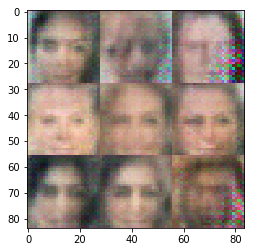

Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 11.3537
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 7.5692
Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 11.9608
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 11.8366
Epoch 1/1... Discriminator Loss: 0.0017... Generator Loss: 8.1374
Epoch 1/1... Discriminator Loss: 0.0016... Generator Loss: 9.3986
Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 9.8163
Epoch 1/1... Discriminator Loss: 0.0018... Generator Loss: 12.5514
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 11.2548
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 8.1767


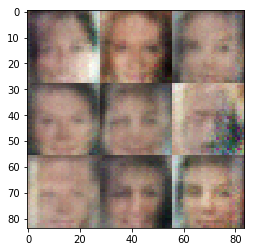

Epoch 1/1... Discriminator Loss: 0.0050... Generator Loss: 13.5355
Epoch 1/1... Discriminator Loss: 0.0112... Generator Loss: 5.1723
Epoch 1/1... Discriminator Loss: 0.0041... Generator Loss: 7.4273
Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 9.2398
Epoch 1/1... Discriminator Loss: 0.0179... Generator Loss: 8.9882
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 8.9161
Epoch 1/1... Discriminator Loss: 0.0073... Generator Loss: 8.2078
Epoch 1/1... Discriminator Loss: 2.5393... Generator Loss: 0.1432
Epoch 1/1... Discriminator Loss: 0.0902... Generator Loss: 6.4627
Epoch 1/1... Discriminator Loss: 0.0412... Generator Loss: 4.3102


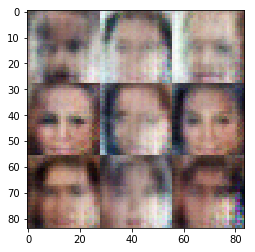

Epoch 1/1... Discriminator Loss: 0.0051... Generator Loss: 8.1926
Epoch 1/1... Discriminator Loss: 0.0224... Generator Loss: 5.8638
Epoch 1/1... Discriminator Loss: 0.0043... Generator Loss: 6.2100
Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 9.0587
Epoch 1/1... Discriminator Loss: 1.7276... Generator Loss: 7.9677
Epoch 1/1... Discriminator Loss: 0.0479... Generator Loss: 3.9471
Epoch 1/1... Discriminator Loss: 0.0188... Generator Loss: 9.4402


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.